<a href="https://colab.research.google.com/github/Hackman-git/Mechanisms_of_action/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
train_x = pd.read_csv('/content/drive/My Drive/MOA/Data/train_features.csv')
train_y = pd.read_csv("/content/drive/My Drive/MOA/Data/train_targets_scored.csv")
test = pd.read_csv("/content/drive/My Drive/MOA/Data/test_features.csv")
submit = pd.read_csv("/content/drive/My Drive/MOA/Data/sample_submission.csv")

In [3]:
train_x.shape

(23814, 876)

875 features in the dataset

In [4]:
train_y.shape

(23814, 207)

206 targets, multioutput classification

In [5]:
submit.shape

(3982, 207)

In [6]:
train_x.head(3)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


In [7]:
train_y.head(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
submit.head(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,id_002429b5b,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


We have 772 gene expression features

In [9]:
cols = train_x.columns
gene_cols = [col for col in cols if col.startswith('g-')]
gene_cols_count = len(gene_cols)

gene_cols_count

772

and 100 cell viability features

In [10]:
cell_cols = [col for col in cols if col.startswith("c-")]
cell_cols_count = len(cell_cols)

cell_cols_count

100

Distribution of the more expressive features

In [11]:
# distribution of testing time
d = train_x.groupby('cp_time')['sig_id'].count().reset_index()
d= d.rename(columns={'sig_id':'count'})
fig = px.bar(d, x='cp_time', y='count')
fig.update_layout(width=800, height=300)
fig.show()

In [12]:
# distribution of dosage
d = train_x.groupby('cp_dose')['sig_id'].count().reset_index()
d= d.rename(columns={'sig_id':'count'})
fig = px.bar(d, x='cp_dose', y='count')
fig.update_layout(width=800, height=300)
fig.show()

In [13]:
# distribution on treatment type
d = train_x.groupby('cp_type')['sig_id'].count().reset_index().rename(columns={'sig_id':'count'})
fig = px.bar(d, x='cp_type', y='count')
fig.update_layout(width=800, height=300)
fig.show()

In [14]:
test.cp_type.value_counts()

trt_cp         3624
ctl_vehicle     358
Name: cp_type, dtype: int64

### Explore targets

What's the distibution of the count of cell activations for the drug samples

In [15]:
temp = train_y.copy()
temp['total'] = temp.sum(axis=1, numeric_only=True)
d = temp.groupby('total')['sig_id'].count().reset_index().rename(columns={'sig_id':'count', 'total':'num_of_cells_activated'})
fig = px.bar(d, x='num_of_cells_activated', y='count')
fig.update_layout(width=800, height=400)
fig.show()


we have 9367 observations with all zeros as targets. Those must be the control treatments. We also have most samples having 1 or 2 mechanism(s) of action

What classes are most prominent

In [16]:
d = dict()
for i in train_y.columns[1:]:
    d[i] = train_y[i].sum()
temp = pd.Series(d)
temp = pd.DataFrame(temp).reset_index()
temp.columns = ['target', 'count']
temp = temp.sort_values('count', ascending=False)
fig = px.bar(temp[:20], x='count', y='target', orientation='h')
fig.update_layout(width=800, height=500)
fig.show()

We see that Inhibitors seem to be the most prominent cell types in the train targets

In [17]:
med = temp['count'].median()
med

38.5

A median occurence of ~39 means most of the targets rarely occur. The data is severly imbalanced

At this point it is important to note that there are certain groups of targets

In [18]:
targets = train_y.columns[1:]

In [19]:
kind = []
for i in targets:
    if len(i.split('_')) > 1:
        kind.append(i.split('_')[-1])
kind = list(set(kind))
print(kind)

['scavenger', 'activator', 'inhibitor', 'b', 'antagonist', 'stimulant', 'blocker', 'agonist', 'antifolate', 'agent', 'local', 'medium', 'donor', 'sensitizer', 'secretagogue']


In [20]:
d = dict()
for i in kind:
    d[i] = len([j for j in targets if j.endswith('_'+i)])

temp = pd.DataFrame(pd.Series(d)).reset_index()
temp.columns =['target', 'count']
temp = temp[temp['count'] > 1].sort_values('count', ascending=False)

fig = px.bar(temp, x='target', y='count')
fig.update_layout(width=800, height=300)
fig.show()

We have most targets as "Inhibitors", "agonists", and "antagonists"

In [21]:
inhibitors = [i for i in targets if i.endswith('_inhibitor')]
agonists = [i for i in targets if i.endswith('_agonist')]
antagonists = [i for i in targets if i.endswith('_antagonist')]
activators = [i for i in targets if i.endswith('_activator')]

Correlation

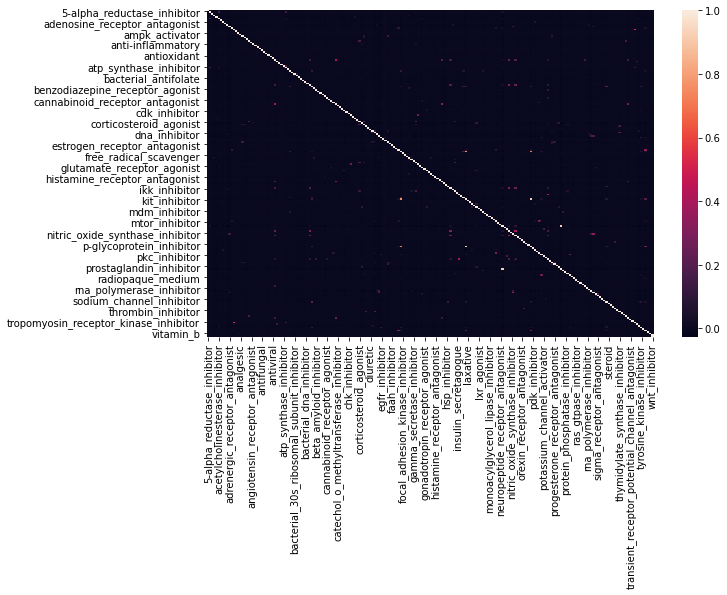

In [129]:
correl = train_y[targets].corr()
plt.figure(figsize=(10,6))
sns.heatmap(correl)
plt.show()

Let's look more closely at top pairwise correlations

In [135]:
c = correl.unstack().sort_values(ascending=False)[206:].to_frame().reset_index()
c.columns=['col1', 'col2', 'corr']

In [136]:
top = c[c['corr'] >= 0.7]
top.shape[0]/2

4.0

We have four pairwise strongly positive correlations in the targets

In [137]:
top

,col1,col2,corr
0,proteasome_inhibitor,nfkb_inhibitor,0.921340
1,nfkb_inhibitor,proteasome_inhibitor,0.921340
2,kit_inhibitor,pdgfr_inhibitor,0.915603
3,pdgfr_inhibitor,kit_inhibitor,0.915603
4,flt3_inhibitor,kit_inhibitor,0.758112
5,kit_inhibitor,flt3_inhibitor,0.758112
6,flt3_inhibitor,pdgfr_inhibitor,0.705119
7,pdgfr_inhibitor,flt3_inhibitor,0.705119


Highly correlated targets to look out for
*   Proteasome_inhibitor
*   nfkb_inhibitor
*   kit_inhibitor
*   pdgfr_inhibitor
*   flt3_inhibitor



### Explore features

Let's study the anonymized features (gene expression and cell viability)

Subset the train set for compound treatment of Cp_type

In [23]:
train_features = train_x[train_x['cp_type'] == 'trt_cp']
train_features.shape

(21948, 876)

Let's study correlations in the cell vialbility features

In [41]:
sub = train_features[cell_cols]
corr_matrix = sub.corr()
c = corr_matrix.unstack().sort_values(ascending=False)[100:].to_frame().reset_index()
c.columns=['col1', 'col2', 'corr']
c

,col1,col2,corr
0,c-52,c-42,0.927873
1,c-42,c-52,0.927873
2,c-13,c-73,0.924338
3,c-73,c-13,0.924338
4,c-13,c-26,0.924001
...,...,...,...
9895,c-58,c-74,0.664659
9896,c-37,c-22,0.656201
9897,c-22,c-37,0.656201
9898,c-16,c-22,0.619002


<Figure size 864x576 with 0 Axes>

How many pairwise features are highly correlated (> 0.8)

In [46]:
temp = c[c['corr'] >= 0.8]
temp.shape[0]/2

4187.0

There are 4187 highly correlated pairs of cell features out of the possible 4950 pairs. That's a lot. There's also no negative correlations. We may want to look at dimensionality reduction to avoid collinearity

Let's see the distribution of a few cell viab features

In [114]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=4, column_titles=['c-10','c-40', 'c-60', 'c-90'])

trace1 = go.Histogram(x=train_features['c-10'])
trace2 = go.Histogram(x=train_features['c-40'])
trace3 = go.Histogram(x=train_features['c-60'])
trace4 = go.Histogram(x=train_features['c-90'])

fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=1, col=3)
fig.add_trace(trace4, row=1, col=4)

fig.update_layout(width=1000, height=400)
fig.show()

There seems to be 2 peaks in the distributions of cell features; one around 0 and another around -10

Gene expression features

Correlation

In [116]:
sub = train_features[gene_cols]
corr_matrix = sub.corr()
g = corr_matrix.unstack().sort_values(ascending=False)[772:].to_frame().reset_index()
g.columns=['col1', 'col2', 'corr']
g

,col1,col2,corr
0,g-37,g-50,0.912383
1,g-50,g-37,0.912383
2,g-672,g-50,0.851694
3,g-50,g-672,0.851694
4,g-37,g-489,0.850502
...,...,...,...
595207,g-460,g-228,-0.815484
595208,g-248,g-760,-0.822524
595209,g-760,g-248,-0.822524
595210,g-228,g-349,-0.828494


In [120]:
g_pos = g[g['corr'] >= 0.8]
g_pos.shape[0]/2

34.0

We have only 34 highly positively correlated pairwise gene expression features. Let's relax the condition to 0.7

In [124]:
g_pos = g[g['corr'] >= 0.7]
g_pos.shape[0]/2

562.0

We have 562 with pairwise positive correlation above 0.7

In [123]:
g_neg = g[g['corr'] <= -0.7]
g_neg.shape[0]/2

342.0

342 pairwise negative correlation below -0.7

Distribution of a few gene expression features

In [138]:
fig = make_subplots(rows=1, cols=4, column_titles=['g-10','g-40', 'g-60', 'g-90'])

trace1 = go.Histogram(x=train_features['g-10'])
trace2 = go.Histogram(x=train_features['g-40'])
trace3 = go.Histogram(x=train_features['g-60'])
trace4 = go.Histogram(x=train_features['g-90'])

fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=1, col=3)
fig.add_trace(trace4, row=1, col=4)

fig.update_layout(width=1000, height=400)
fig.show()